In [30]:
import sys
if '/disks/cosmodm/vdvuurst' not in sys.path:
    sys.path.append('/disks/cosmodm/vdvuurst')

import numpy as np
import h5py
from matplotlib import pyplot as plt
import os
from importlib import reload
import json
from tqdm import tqdm
from functions import *
from onehalo_plotter import format_plot
format_plot()

from scipy.stats import skewnorm, norm
import emcee
from inspect import signature
from corner import corner


In [ ]:

path = '/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.0-13.5_M2_13.5-14.0.hdf5'

with h5py.File(path,'r') as file:
    radial_distances = file['radial_distances'][:]
    velocities = file['velocity_differences'][:]
    prim_masses = file['primary_masses'][:]
    sec_masses = file['secondary_masses'][:]



In [65]:
skewnorm_func = lambda x,a,mu,sigma: skewnorm.pdf(x, a, loc = mu, scale = sigma)

max_radius = 300. #Mpc
number_of_bins = 20

radial_bins = np.logspace(0, np.log10(max_radius), number_of_bins)

bin_indices = np.digitize(radial_distances, bins = radial_bins) - 1
num_bins = len(radial_bins) - 1  
# for bin_idx in range(num_bins):
bin_idx = 5

# break

def log_prior(theta):
    a, mu, sigma = theta

    if -4. < a < 4. and 1. < sigma < 1500. and -500. < mu < 1.:
        return 0.0
    
    return -np.inf

def skew_gaussian_log_likelihood(params, data): #full with prior
    prior = log_prior
    lp = prior(params)
    if not np.isfinite(lp):
        return -np.inf

    mu_func = skewnorm_func
    mu_i = mu_func(data, *params)
    mu_i[mu_i < 0] = 0. # cast negative values to 0, raises errors otherwise
    return np.sum(np.log(mu_i)) + 1. #+1. for integral, chose log10 to stay consistent

def run_two_halo_emcee(bin_idx, likelihood_func = skew_gaussian_log_likelihood, func = skewnorm_func, nwalkers = 10, nsteps = 1000):
    bin_mask = bin_indices == bin_idx
    bin_velocities = velocities[bin_mask]

    ndim = len(signature(func).parameters) - 1

    pos = np.random.uniform(low = [-4.,-500., 1.,], high = [4., 1., 1500.], size = (nwalkers, ndim))
            
    sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood_func , args = (bin_velocities,))
    sampler.run_mcmc(pos, nsteps, progress = True)

    return bin_velocities, sampler, ndim, nwalkers, nsteps



/var/tmp/vdvuurst/ipykernel_2158732/403627240.py:32: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(mu_i)) + 1. #+1. for integral, chose log10 to stay consistent


BIN IDX 3


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 281.28it/s]


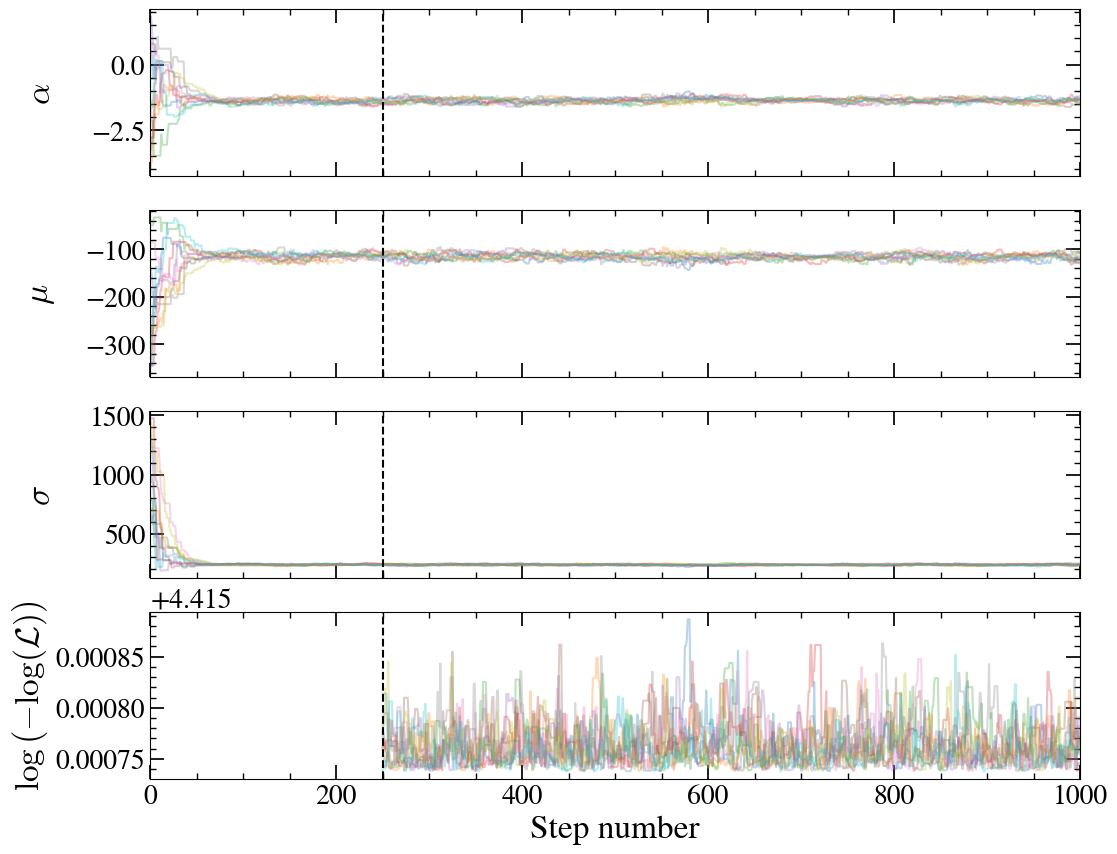

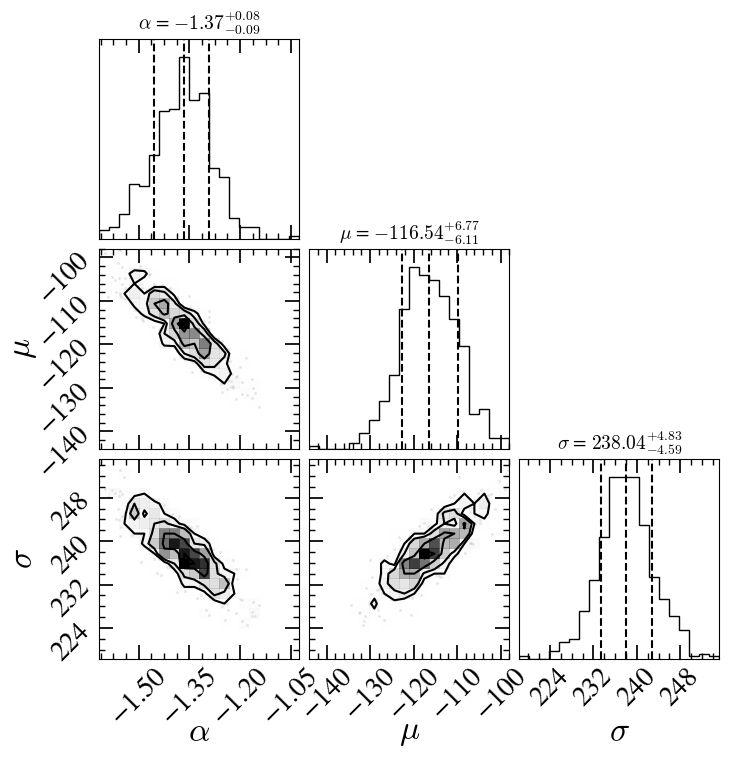

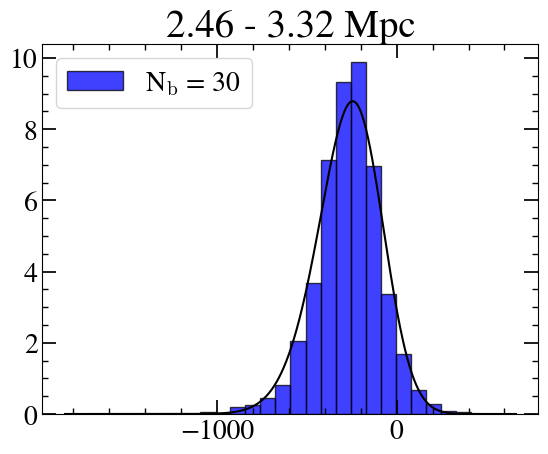

BIN IDX 4


  0%|          | 0/1000 [00:00<?, ?it/s]/var/tmp/vdvuurst/ipykernel_2158732/403627240.py:32: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(mu_i)) + 1. #+1. for integral, chose log10 to stay consistent
100%|██████████| 1000/1000 [00:04<00:00, 237.12it/s]


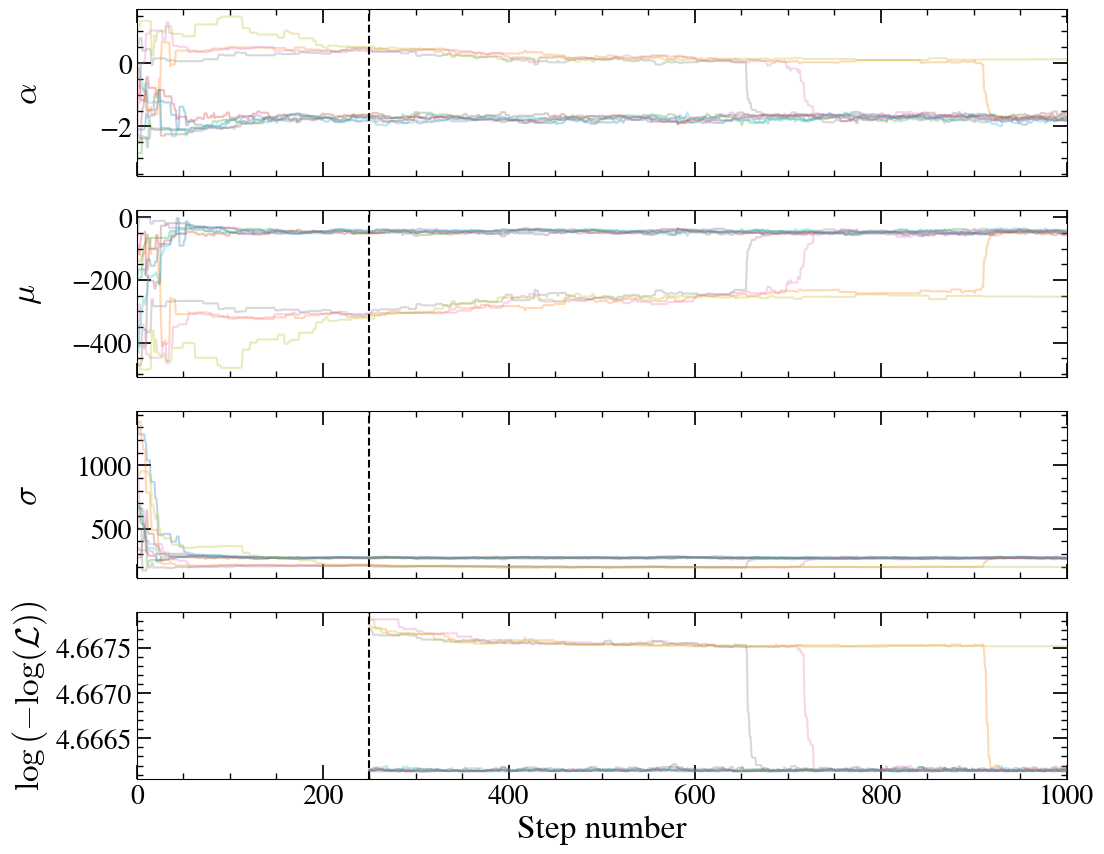

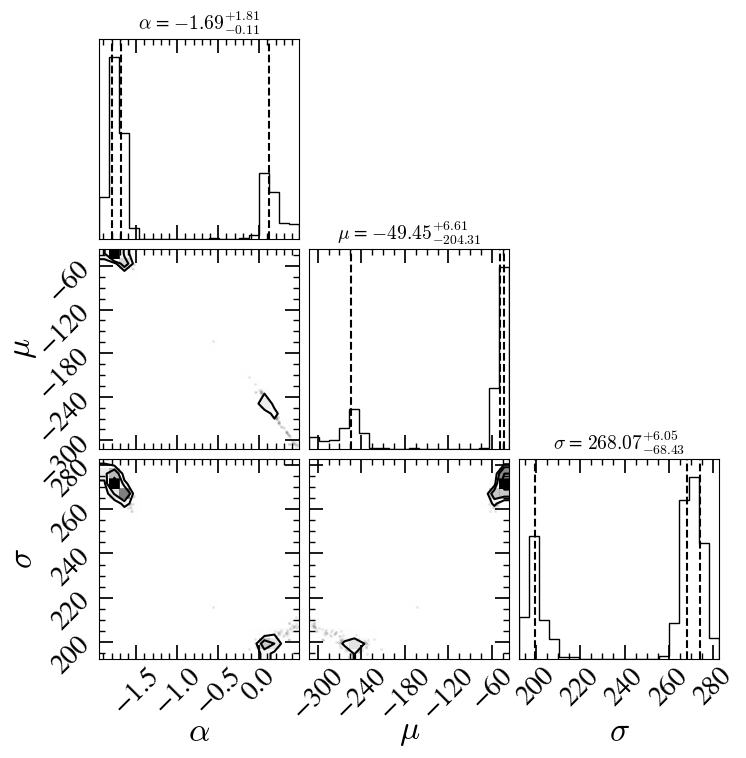

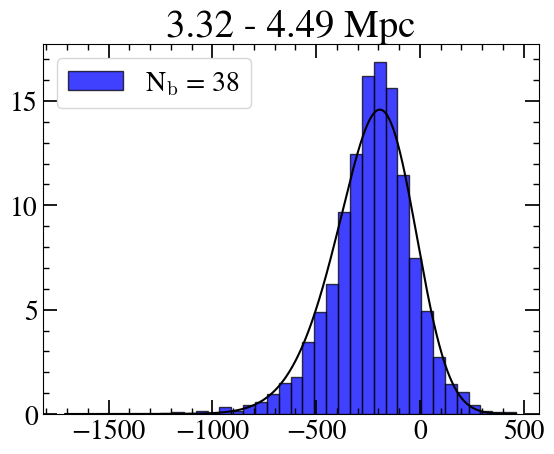

BIN IDX 5


  0%|          | 0/1000 [00:00<?, ?it/s]/var/tmp/vdvuurst/ipykernel_2158732/403627240.py:32: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(mu_i)) + 1. #+1. for integral, chose log10 to stay consistent
100%|██████████| 1000/1000 [00:06<00:00, 152.25it/s]


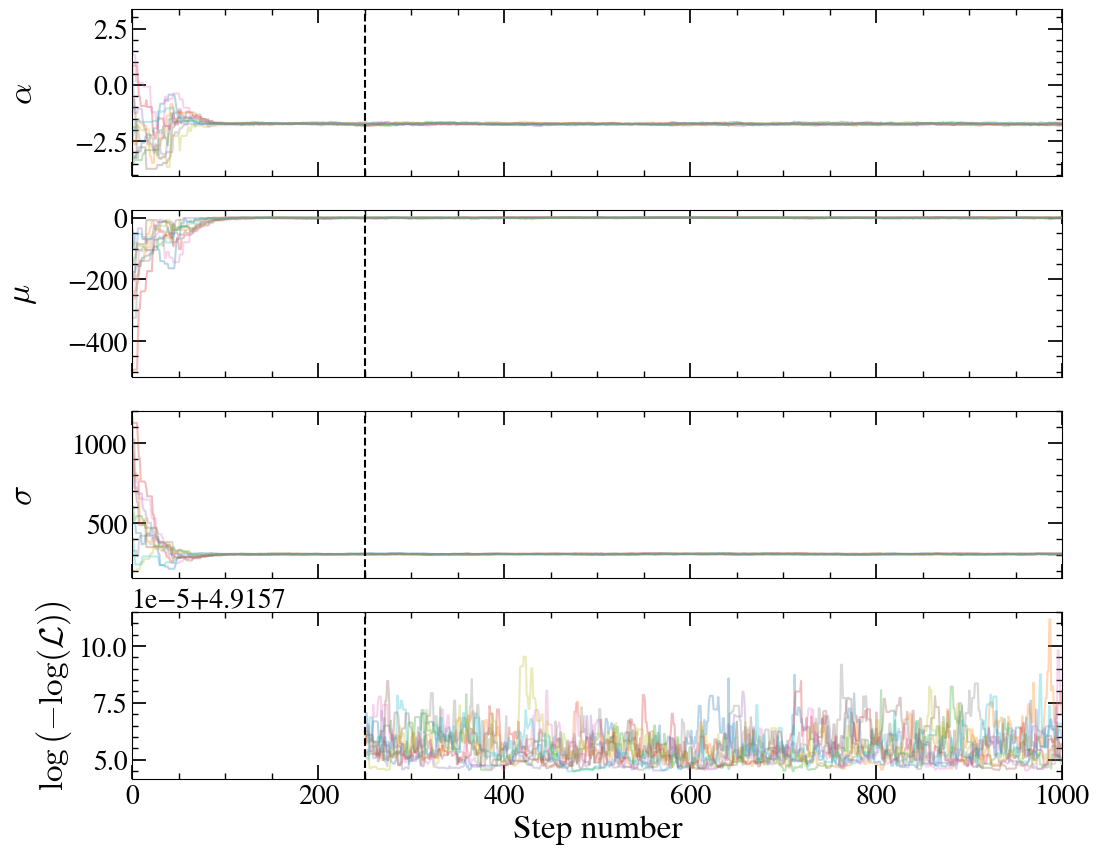

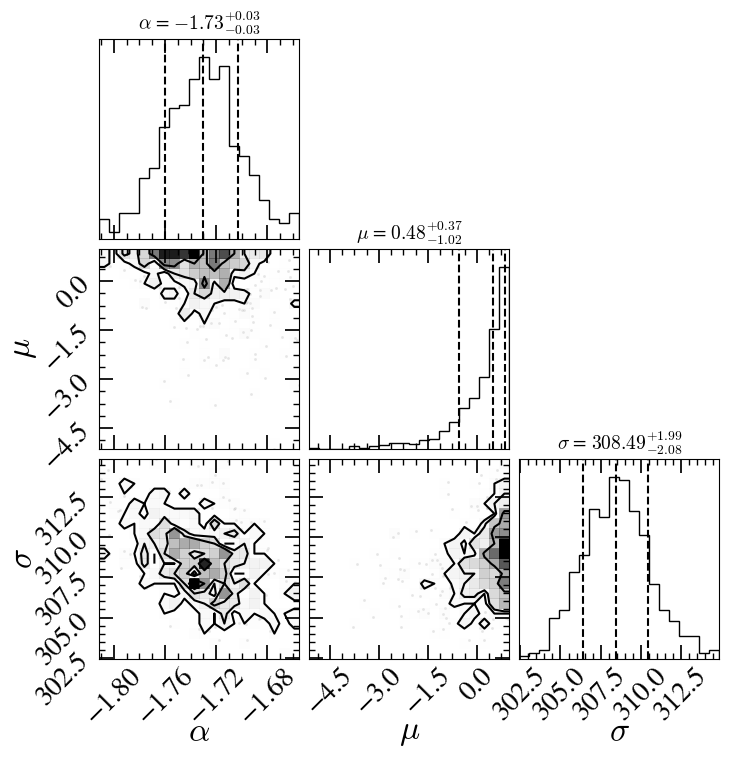

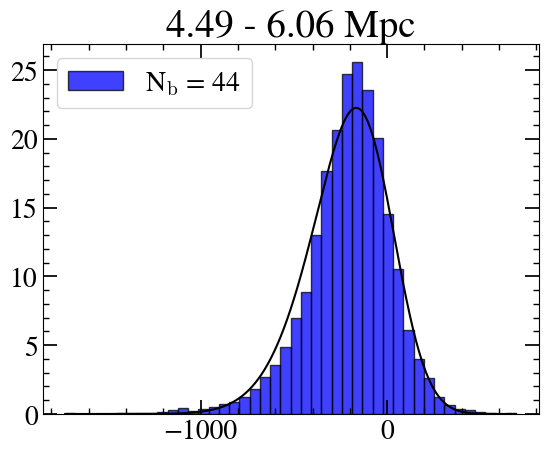

/var/tmp/vdvuurst/ipykernel_2158732/403627240.py:32: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(mu_i)) + 1. #+1. for integral, chose log10 to stay consistent


BIN IDX 6


100%|██████████| 1000/1000 [00:09<00:00, 110.80it/s]


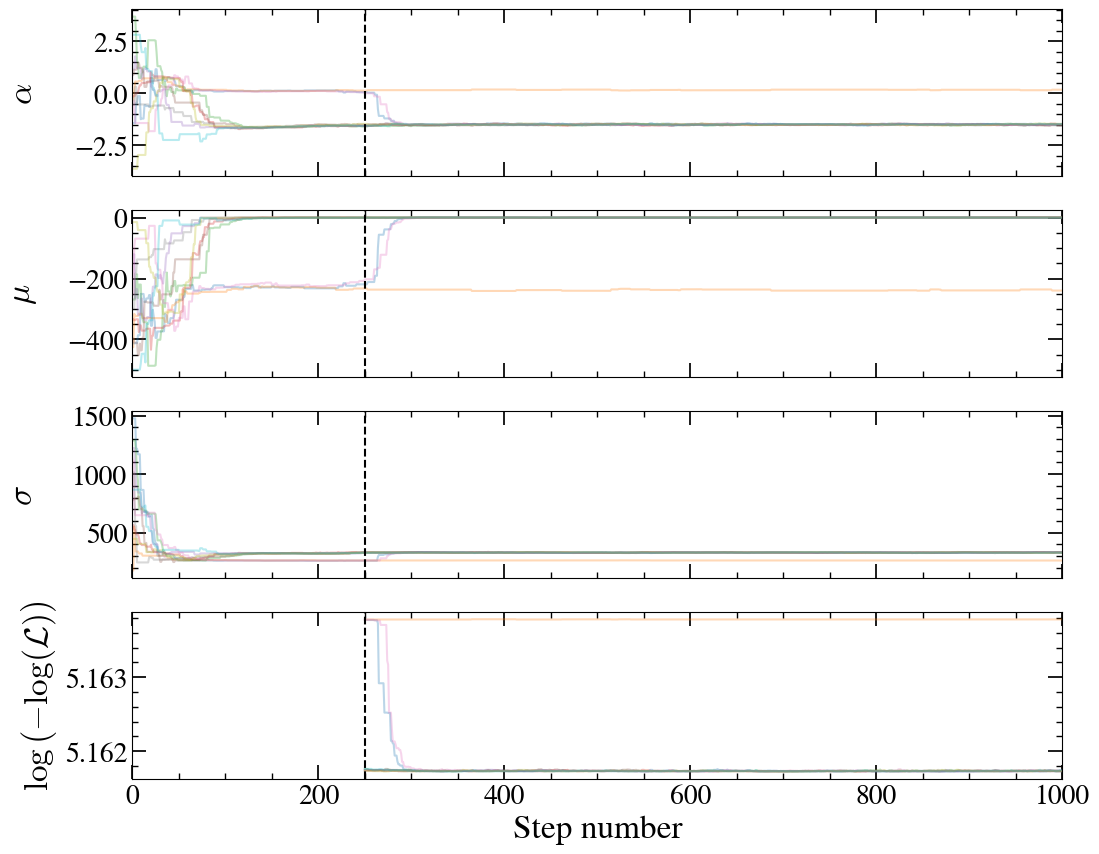

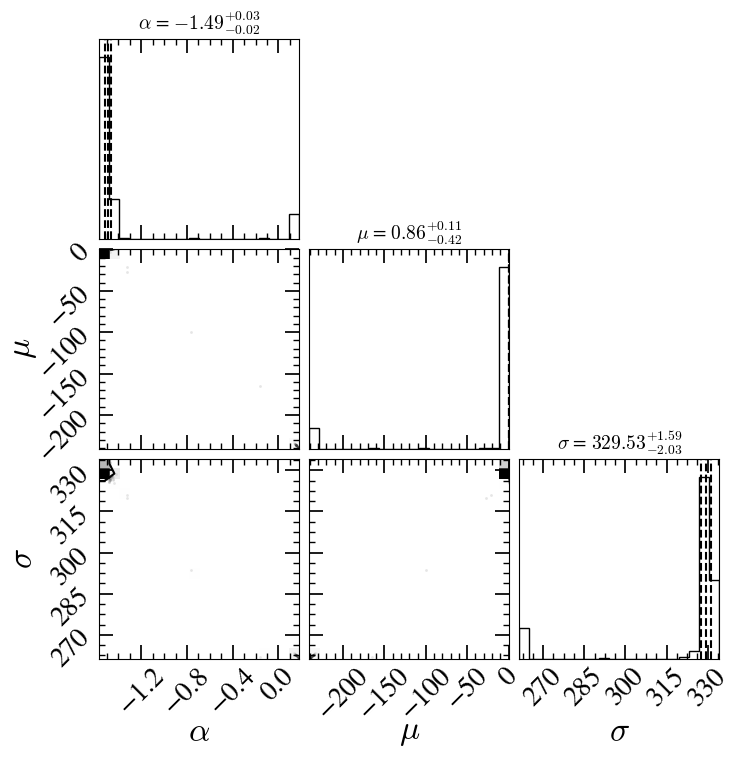

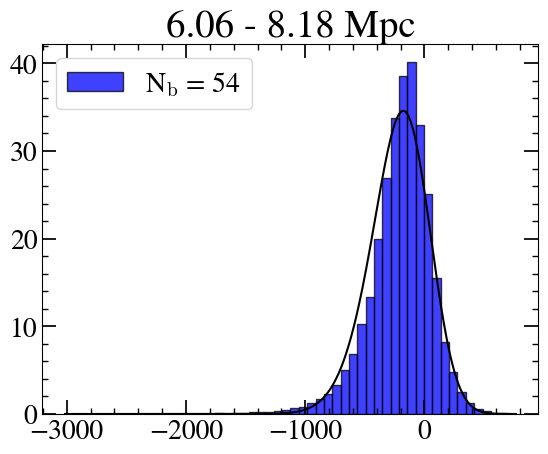

In [66]:
def emcee_plots_twohalo(bin_velocities, sampler, ndim):
    fig, axes = plt.subplots(ndim + 1, figsize=(12, 10), sharex=True)
    samples = sampler.get_chain()

    burnin = 250
    param_labels = [r'$\alpha$',r'$\mu$', r'$\sigma$']
    for i in range(ndim):
        ax:plt.Axes = axes[i]
        ax.plot(samples[:, :, i], alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(param_labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

        ymin, ymax = ax.get_ylim()
        ax.vlines(burnin, ymin, ymax, colors = 'black', linestyles = '--')
        ax.set_ylim(ymin, ymax)

    likelihoods = sampler.get_log_prob()
    best_arg = np.unravel_index(np.argmax(likelihoods), likelihoods.shape) # we want the MAXIMUM likelihood here, not the minimum negative likelihood (which would be equivalent)
    best_likelihood = likelihoods[*best_arg]
    best_params = np.array([samples[*best_arg, i] for i in range(ndim)])

    flat_samples = sampler.get_chain(discard=burnin, thin=15, flat=True) # this is probably fine

    result = np.zeros(ndim)
    errs = np.zeros((3,2))
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        err = np.diff(mcmc)
        
        result[i] = mcmc[1]
        errs[i,0] = err[0]
        errs[i,1] = err[1]

    likelihoods_plot = np.log10(-1 * likelihoods)
    likelihoods_plot[:burnin] = np.nan # so that the lines are better discernable in the plot

    axes[-1].plot(likelihoods_plot, alpha = 0.3)
    axes[-1].set(ylabel = r'$\log\left(-\log(\mathcal{L})\right)$')
    # axes[-1].yaxis.set_label_coords(-0.15, 0.5)
    # axes[-1].ticklabel_format(useOffset = True)
    # axes[-1].set_yscale('log')
    axes[-1].set_xlabel("Step number")

    ymin, ymax = axes[-1].get_ylim()
    axes[-1].vlines(burnin, ymin, ymax, colors = 'black', linestyles = '--')
    axes[-1].set_ylim(ymin, ymax)
    plt.show()
    # plt.savefig(f'{filename}_walkers{loglambda_str}.png', dpi = 200)
    # plt.close()

    #corner plot

    fig = corner(flat_samples, labels = param_labels, quiet = True,
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize':14})

    plt.show(fig)
    # fig.savefig(f"{filename}_corner{loglambda_str}.png", dpi = 200)
    # plt.close(fig)

    # print(best_params)
    # for res,err in zip(result, errs):
    #     print(f'{res} + {err[0]} - {err[-1]}')

    plt.figure()
    plt.title(f'{radial_bins[bin_idx]:.2f} - {radial_bins[bin_idx + 1]:.2f} Mpc')

    bins=rice_bins(bin_velocities.size)

    bin_heights, bin_edges = np.histogram(bin_velocities, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width= bin_edges[1] - bin_edges[0] 
    bin_widths = np.diff(bin_edges)  # The width of each bin
    number_density = bin_heights / bin_widths  # Normalize by bin width

    plt.bar(bin_centers, number_density, width=bin_width, align='center', edgecolor = 'black',
            alpha=0.75, color='b', label = "N" + r'$_\mathrm{b}$' + f" = {rice_bins(bin_velocities.size)}")

    DAT=np.linspace(np.min(bin_velocities),np.max(bin_velocities),1000)
    hist_area=np.sum(bin_heights)
    plt.plot(DAT, hist_area * skewnorm_func(DAT, *best_params), c='black')

    plt.legend()
    plt.show()


for bin_idx in range(3,7):
    print(f'BIN IDX {bin_idx}')
    bin_velocities, sampler, ndim, nwalkers, nsteps = run_two_halo_emcee(bin_idx)
    emcee_plots_twohalo(bin_velocities, sampler, ndim)

